# Simon's Algorithm Experimental Verification

Simon’s algorithm aims to find a hidden bitmask string `s` such that for a given function `f`, the equality

$$
f(x) = f(x \oplus s)
$$

holds for all `x`, where \( \oplus \) denotes the bitwise XOR operation. In our experiment, we use `s = "1101"`. Our main goals are to observe how noise affects the algorithm and to validate a theoretical noise threshold through metrics like bias and entropy.

Below is an explanation of each method used in the code, highlighting their functions and relevance to our experimental objectives.



In [414]:

import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors, depolarizing_error
import matplotlib.pyplot as plt
from math import log2
from qiskit.visualization import plot_distribution, plot_histogram
global op_counts

### `calculate_bias_entropy(output_map, unwanted_states)`

**Purpose:**  
This function computes two key metrics for assessing the output of Simon's algorithm in the presence of noise:

- **Bias (β):**  
  Quantifies the fraction of measurement outcomes that are "unwanted" (i.e., those states that do not satisfy the required condition \( y \cdot s = 0 \) modulo 2). A high bias indicates that noise or bugs have introduced errors into the measurement distribution.
  
- **Entropy (S):**  
  Measures the overall uncertainty or randomness in the measurement distribution via the Shannon entropy formula. Higher entropy suggests greater randomness, which is expected under significant noise, but deviations from theoretical expectations can indicate anomalies.

**Functionality:**  
1. **Total Count Calculation:**  
   Determines the total number of shots by summing all the measurement counts.
   
2. **Bias Calculation:**  
   Iterates through the output map (measurement results) and accumulates the probability weight of the outcomes that are in the list of unwanted states.
   
3. **Entropy Calculation:**  
    Calculates the entropy of the measurement distribution, providing a quantitative measure of uncertainty or randomness in the outcomes.






In [415]:
def calculate_bias_entropy(output_map, unwanted_states):
    total_count = sum(output_map.values())

    bias = 0
    count = 0
    for key, val in output_map.items():
        if key in unwanted_states:
            bias += val / total_count
        count += 1

    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return bias, entropy


### `create_noise_model(p)`

**Purpose:**  
Creates a depolarizing noise model for the simulation.

**Functionality:**  
- Applies depolarizing errors to both single-qubit gates and two-qubit (`cx`) gates.
- Uses an error parameter `p` to scale the depolarizing error probabilities.

**Relevance to Experimental Goals:**  
- **Noise Simulation:** By varying `p` (e.g., 0 for noiseless, 0.3 for moderate noise, and 0.65 for high noise), we simulate different real-world environments.
- **Threshold Verification:** Comparing experimental results with different `p` values against the theoretical noise threshold (e.g., \( p^* = 0.0625 \)) helps determine when the noise begins to significantly alter the algorithm’s output.



In [416]:
def create_noise_model(p):
    noise_model = NoiseModel()

    error = depolarizing_error(4*p/3, 1)
    noise_model.add_all_qubit_quantum_error(error, ['id', 'u', 'u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])
    
    error = depolarizing_error(16*p/15, 2)
    noise_model.add_all_qubit_quantum_error(error, ['cx'])
    
    return noise_model

In [417]:
def simon_function(s: str):
    """
    Create a QuantumCircuit implementing a query gate for Simon problem obeying the promise for the hidden string `s`
    """
    n = len(s)
    qc = QuantumCircuit(2 * n)
    pi = np.random.permutation(2**n)

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    qc.unitary(query_gate, range(2 * n))
    return qc

# Calculating the Threshold for Simon's Measurement Circuit

This function, `calculate_threshold_with_measurement`, determines the per-gate error threshold for a complete Simon measurement circuit without decomposing the gates further. 

The function assembles the full Simon measurement circuit by:

1. Creating a circuit with \(2n\) qubits and \(n\) classical bits.
2. Applying Hadamard gates on the first \(n\) qubits.
3. Composing the provided Simon oracle (`problem`) into the circuit.
4. Applying an additional Z gate on qubit 0, followed by another round of Hadamard gates on the first \(n\) qubits.
5. Adding measurement instructions on the first \(n\) qubits.

After building the circuit, the function counts the gate operations (ignoring `'barrier'` and `'measure'`) and computes the threshold using the formula above. If no gate operations are detected, it prints a warning and returns `None`.

Below is the complete implementation.


In [418]:
def calculate_threshold_with_measurement(problem: QuantumCircuit, unwanted_count: int, reps: int = 10) -> float:
    
    n = problem.num_qubits // 2
    
    # Build the full Simon measurement circuit.
    qc_full = QuantumCircuit(2 * n, n)
    qc_full.h(range(n))
    qc_full.compose(problem, inplace=True)
    qc_full.z(0)
    qc_full.h(range(n))
    qc_full.measure(range(n), range(n))
    
    # Count the operations directly (without decomposing).
    ops = qc_full.count_ops()
    gate_count = sum(val for key, val in ops.items() if key not in ['barrier', 'measure'])
    
    if gate_count == 0:
        print("Warning: No gate operations were counted (excluding 'barrier' and 'measure').")
        return None
    
    DS = 8  # fixed value for DS
    threshold_probability = 1 - ((2**n - DS) / (2**n))  # This simplifies to DS/2**n
    expected_threshold = threshold_probability / gate_count
    
    print("Expected per-gate threshold:", expected_threshold)
    
    return expected_threshold


In [419]:
def simon_measurements(problem: QuantumCircuit, k: int, noise_model):
    """
    Quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    implements f, get `k` measurements to be post-processed later.
    """
    n = problem.num_qubits // 2
    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True) 
    qc.h(range(n))
    qc.measure(range(n), range(n))
    result = AerSimulator(noise_model=noise_model).run(qc, shots=k, memory=True).result()
    op_counts=qc.count_ops
    return result.get_counts()

In [420]:
def simon_measurements_buggy (problem: QuantumCircuit, k: int, noise_model):
    n = problem.num_qubits // 2
    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True) 
    qc.h(range(n))
    qc.x(range(n))
    qc.measure(range(n), range(n))
    result = AerSimulator(noise_model=noise_model).run(qc, shots=k, memory=True).result()
    op_counts=qc.count_ops
    return result.get_counts()

### `to_bin(number, num_bits)`

**Purpose:**  
Converts an integer into its fixed-length binary string representation.

### `simons_non_ys(s)`

**Purpose:**  
Generates a list of binary strings (of length n) that are considered "unwanted" based on Simon's problem.

In [421]:


def to_bin(number, num_bits):
    return format(number, f'0{num_bits}b')


def simons_non_ys(s):
    n = len(s)
    l=[]

    for i in range(0, pow(2,n)):
        y = to_bin(i, n)
        dot=0
        for p in range(n):
            dot+=int(y[p], 2) * int(s[p], 2)
        if dot%2 != 0:
            l.append(y)
    return l

## Running the Simulation and Plotting the Results

The following code executes the simulation of Simon's algorithm with a noiseless environment (noise level `p = 0.0`), computes key metrics, and plots the histogram of the measurement outcomes.


Unwanted states: ['0001', '0011', '0100', '0110', '1000', '1010', '1101', '1111']
bias: 0, entropy: 2.9986300877160437


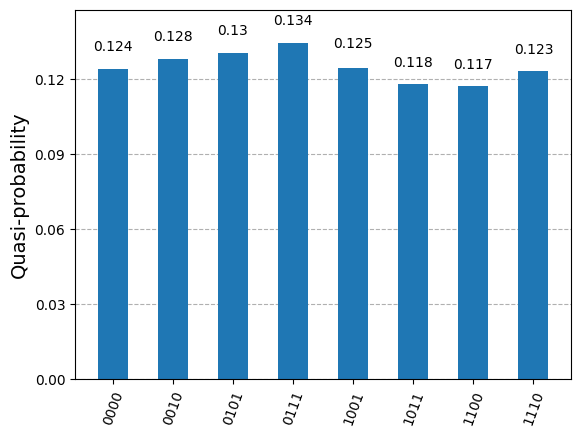

In [422]:

shots = 10000
s = '1101'
unwanted = simons_non_ys(s)
print("Unwanted states:", unwanted)
results = simon_measurements(simon_function(s), k=shots, noise_model=create_noise_model(0.0))
arr = calculate_bias_entropy(results, unwanted)
print(f"bias: {arr[0]}, entropy: {arr[1]}")

# Convert the counts into quasi probability distribution
quasi_probs = {state: count/shots for state, count in results.items()}

# Plot the histogram with the quasi probabilities
plot_histogram(quasi_probs)


In [423]:
problem_circuit = simon_function(s)
unwanted_count=len(unwanted)
threshold = calculate_threshold_with_measurement(problem_circuit, unwanted_count, reps=10)
print("Threshold for Simon's algorithm circuit (including measurement operations):", threshold)

Expected per-gate threshold: 0.05
Threshold for Simon's algorithm circuit (including measurement operations): 0.05


The following code executes the simulation of Simon's algorithm with a low noise environment (noise level `p = 0.02`), and plots the histogram of the measurement outcomes.


Unwanted states: ['0001', '0011', '0100', '0110', '1000', '1010', '1101', '1111']
bias: 0.0743, entropy: 3.3802181580645225


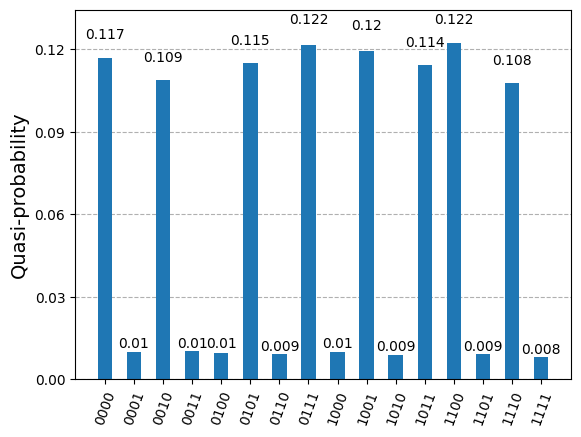

In [424]:
shots = 10000
s = '1101'
unwanted = simons_non_ys(s)
print("Unwanted states:", unwanted)
results = simon_measurements(simon_function(s), k=shots, noise_model=create_noise_model(0.02))
arr = calculate_bias_entropy(results, unwanted)
print(f"bias: {arr[0]}, entropy: {arr[1]}")

# Convert the counts into quasi probability distribution
quasi_probs = {state: count/shots for state, count in results.items()}

# Plot the histogram with the quasi probabilities
plot_histogram(quasi_probs)

The following code executes the simulation of Simon's algorithm with noise at threshold (noise level `p = 0.05`), and plots the histogram of the measurement outcomes.


Unwanted states: ['0001', '0011', '0100', '0110', '1000', '1010', '1101', '1111']
bias: 0.1717, entropy: 3.6604653507228253


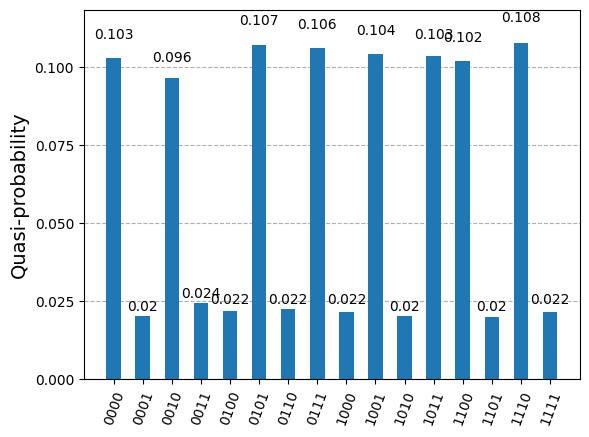

In [425]:
shots = 10000
s = '1101'
unwanted = simons_non_ys(s)
print("Unwanted states:", unwanted)
results = simon_measurements(simon_function(s), k=shots, noise_model=create_noise_model(0.05))
arr = calculate_bias_entropy(results, unwanted)
print(f"bias: {arr[0]}, entropy: {arr[1]}")

# Convert the counts into quasi probability distribution
quasi_probs = {state: count/shots for state, count in results.items()}

# Plot the histogram with the quasi probabilities
plot_histogram(quasi_probs)

Unwanted states: ['0001', '0011', '0100', '0110', '1000', '1010', '1101', '1111']
bias: 0.8918, entropy: 3.493286086499766


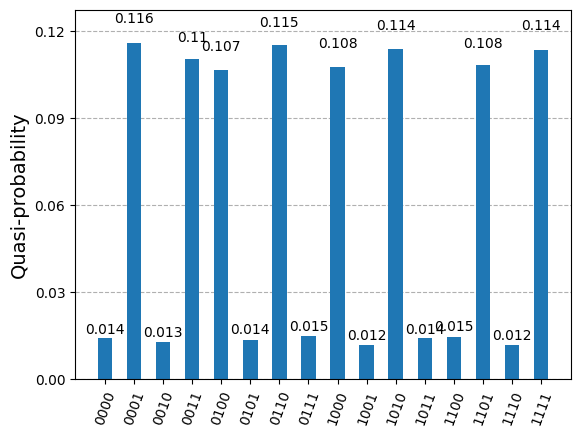

In [426]:
shots = 10000
s = '1101'
unwanted = simons_non_ys(s)
print("Unwanted states:", unwanted)
results = simon_measurements_buggy(simon_function(s), k=shots, noise_model=create_noise_model(0.02))
arr = calculate_bias_entropy(results, unwanted)
print(f"bias: {arr[0]}, entropy: {arr[1]}")

# Convert the counts into quasi probability distribution
quasi_probs = {state: count/shots for state, count in results.items()}

# Plot the histogram with the quasi probabilities
plot_histogram(quasi_probs)